# Phase 4 · Decoder Training Notebook

This notebook trains a lightweight segmentation decoder on the precomputed cuDNN feature tensors, producing lesion masks and baseline metrics ready for benchmarking against prior phases.

## Workflow outline

1. Load the manifest produced during cuDNN feature extraction and build stratified train/validation/test splits.
2. Wrap feature tensors and masks in a PyTorch `Dataset`/`DataLoader` pair with lightweight augmentations.
3. Train a transposed-convolution decoder to upsample 32×56×56 feature maps into 224×224 lesion masks.
4. Track Dice/BCE metrics, evaluate on the hold-out set, and visualize qualitative predictions.

In [3]:
import os
import csv
import json
import math
import random
from collections import Counter
from contextlib import nullcontext
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Sequence, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from IPython.display import HTML, display
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

PROJECT_ROOT = Path.cwd().resolve().parent
FEATURE_ROOT = PROJECT_ROOT / "data_features"
MASK_ROOT = PROJECT_ROOT / "data_processed"
IMAGE_ROOT = PROJECT_ROOT / "data_processed"
MANIFEST_PATH = FEATURE_ROOT / "manifest.csv"
ARTIFACT_DIR = PROJECT_ROOT / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True)

CLASS_TO_IDX = {"Benign": 0, "Malignant": 1}
IDX_TO_CLASS = {v: k for k, v in CLASS_TO_IDX.items()}

SEED = 42
BATCH_SIZE = 16
NUM_EPOCHS = 60
LEARNING_RATE = 1e-3
TRAIN_FRAC = 0.7
VAL_FRAC = 0.2
TEST_FRAC = 0.1
LIMIT_PER_CLASS: int | None = None  # will default to the minority-class count for balance
DICE_LOSS_WEIGHT = 0.7
USE_POS_WEIGHT = False

if not math.isclose(TRAIN_FRAC + VAL_FRAC + TEST_FRAC, 1.0, rel_tol=1e-4):
    raise ValueError("Train/val/test fractions must sum to 1.0")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP_ENABLED = DEVICE.type == "cuda"

def set_global_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = AMP_ENABLED

def autocast_context(enabled: bool = AMP_ENABLED):
    if enabled and DEVICE.type == "cuda":
        amp_module = getattr(torch, "amp", None)
        if amp_module is not None and hasattr(amp_module, "autocast"):
            autocast_fn = amp_module.autocast
            for args in (("cuda",), (),):
                try:
                    return autocast_fn(*args)
                except TypeError:
                    continue
        return torch.cuda.amp.autocast()
    return nullcontext

def create_grad_scaler(enabled: bool = AMP_ENABLED):
    if not enabled or DEVICE.type != "cuda":
        return None
    amp_module = getattr(torch, "amp", None)
    if amp_module is not None and hasattr(amp_module, "GradScaler"):
        grad_scaler_cls = amp_module.GradScaler
        for args in (("cuda",), (),):
            try:
                return grad_scaler_cls(*args, enabled=enabled)
            except TypeError:
                continue
    return torch.cuda.amp.GradScaler(enabled=enabled)

set_global_seed(SEED)

print(f"Using device: {DEVICE}")
print(f"Manifest entries located at: {MANIFEST_PATH}")

Using device: cuda
Manifest entries located at: C:\Users\DHEERAJ\Documents\hpc2\data_features\manifest.csv


In [ ]:
def load_manifest(
    manifest_path: Path,
    feature_root: Path,
    mask_root: Path,
    image_root: Path,
) -> List[Dict[str, object]]:
    """Parse the feature manifest and resolve absolute paths."""
    entries: List[Dict[str, object]] = []
    with manifest_path.open("r", newline="") as handle:
        reader = csv.DictReader(handle)
        for row in reader:
            class_name = row["class"]
            feature_path = (feature_root / row["feature_path"]).resolve()
            mask_path = (mask_root / row["mask_path"]).resolve()
            image_path = (image_root / row["image_path"]).resolve()
            if not feature_path.exists():
                raise FileNotFoundError(f"Missing feature tensor: {feature_path}")
            if not mask_path.exists():
                raise FileNotFoundError(f"Missing mask file: {mask_path}")
            if not image_path.exists():
                raise FileNotFoundError(f"Missing image file: {image_path}")
            entries.append(
                {
                    "class": class_name,
                    "class_idx": CLASS_TO_IDX[class_name],
                    "raw_id": row["raw_id"],
                    "feature_path": feature_path,
                    "mask_path": mask_path,
                    "image_path": image_path,
                }
            )
    return entries


def summarize_manifest(entries: Sequence[Dict[str, object]]) -> None:
    """Display class counts and a quick preview."""
    counts: Dict[str, int] = {cls: 0 for cls in CLASS_TO_IDX}
    for entry in entries:
        counts[entry["class"]] = counts.get(entry["class"], 0) + 1
    summary_df = pd.DataFrame(
        [{"class": cls, "count": count, "ratio": count / len(entries)} for cls, count in counts.items()]
    ).sort_values("class")
    display(summary_df)
    preview_df = pd.DataFrame(entries[:5])[["class", "raw_id", "feature_path", "mask_path"]]
    display(preview_df)


all_entries = load_manifest(MANIFEST_PATH, FEATURE_ROOT, MASK_ROOT, IMAGE_ROOT)
print(f"Loaded {len(all_entries):,} manifest entries")
summarize_manifest(all_entries)

In [111]:
def stratified_split(
    entries: Sequence[Dict[str, object]],
    train_frac: float,
    val_frac: float,
    test_frac: float,
    seed: int = SEED,
    limit_per_class: int | None = None,
 ) -> Tuple[List[Dict[str, object]], List[Dict[str, object]], List[Dict[str, object]]]:
    rng = random.Random(seed)
    grouped: Dict[str, List[Dict[str, object]]] = {}
    for entry in entries:
        grouped.setdefault(entry["class"], []).append(entry)

    train, val, test = [], [], []
    for cls, items in grouped.items():
        rng.shuffle(items)
        if limit_per_class is not None:
            items = items[:limit_per_class]
        n = len(items)
        if n == 0:
            continue
        n_train = max(1, int(round(n * train_frac)))
        n_val = max(1, int(round(n * val_frac)))
        n_test = max(1, n - n_train - n_val)
        while n_train + n_val + n_test > n:
            if n_train > n_val and n_train > 1:
                n_train -= 1
            elif n_val > 1:
                n_val -= 1
            else:
                n_test -= 1
        train.extend(items[:n_train])
        val.extend(items[n_train : n_train + n_val])
        test.extend(items[n_train + n_val : n_train + n_val + n_test])

    rng.shuffle(train)
    rng.shuffle(val)
    rng.shuffle(test)
    return train, val, test


def split_summary(name: str, entries: Sequence[Dict[str, object]]) -> pd.DataFrame:
    counts: Dict[str, int] = {}
    for entry in entries:
        counts[entry["class"]] = counts.get(entry["class"], 0) + 1
    rows = [{"split": name, "class": cls, "count": count} for cls, count in counts.items()]
    return pd.DataFrame(rows)


def compute_class_weights(entries: Sequence[Dict[str, object]]) -> Tuple[Dict[str, float], Dict[str, int]]:
    counts_counter = Counter(entry["class"] for entry in entries)
    total = sum(counts_counter.values())
    num_classes = max(len(counts_counter), 1)
    weights = {cls: total / (num_classes * count) for cls, count in counts_counter.items() if count > 0}
    return weights, dict(counts_counter)


def compute_sample_weights(entries: Sequence[Dict[str, object]], class_weights: Dict[str, float]) -> List[float]:
    return [class_weights[entry["class"]] for entry in entries]


overall_class_counts = Counter(entry["class"] for entry in all_entries)
minority_class_count = min(overall_class_counts.values()) if overall_class_counts else 0
effect_limit_per_class = minority_class_count
if LIMIT_PER_CLASS is not None:
    effect_limit_per_class = min(LIMIT_PER_CLASS, minority_class_count)
print(
    "Overall class counts:",
    dict(overall_class_counts),
)
print(
    f"Balancing to {effect_limit_per_class} samples per class (minority count: {minority_class_count})",
)

train_entries, val_entries, test_entries = stratified_split(
    all_entries,
    train_frac=TRAIN_FRAC,
    val_frac=VAL_FRAC,
    test_frac=TEST_FRAC,
    seed=SEED,
    limit_per_class=effect_limit_per_class,
 )

print(
    f"Samples — train: {len(train_entries)}, val: {len(val_entries)}, test: {len(test_entries)}"
 )
summary_df = pd.concat(
    [split_summary("train", train_entries), split_summary("val", val_entries), split_summary("test", test_entries)]
).pivot(index="split", columns="class", values="count").fillna(0).astype(int)
summary_df["total"] = summary_df.sum(axis=1)
display(summary_df)

train_class_weights, train_class_counts = compute_class_weights(train_entries)
train_sample_weights = compute_sample_weights(train_entries, train_class_weights)
class_weight_df = pd.DataFrame(
    [
        {
            "class": cls,
            "count": train_class_counts.get(cls, 0),
            "weight": weight,
        }
        for cls, weight in train_class_weights.items()
    ]
).sort_values("class")
display(class_weight_df)

Overall class counts: {'Benign': 8283, 'Malignant': 2073}
Balancing to 2073 samples per class (minority count: 2073)
Samples — train: 2902, val: 830, test: 414


class,Benign,Malignant,total
split,,,
test,207,207,414
train,1451,1451,2902
val,415,415,830


,class,count,weight
1,Benign,1451,1.0
0,Malignant,1451,1.0


In [112]:
class FeatureSegmentationDataset(Dataset):
    def __init__(self, entries: Sequence[Dict[str, object]], augment: bool = False) -> None:
        self.entries = list(entries)
        self.augment = augment

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Dict[str, object]:
        entry = self.entries[idx]
        features = np.load(entry["feature_path"])
        feature_tensor = torch.from_numpy(features).float()
        mask_img = Image.open(entry["mask_path"]).convert("L")
        mask = np.asarray(mask_img, dtype=np.float32) / 255.0
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)

        if self.augment:
            feature_tensor, mask_tensor = self._apply_augmentations(feature_tensor, mask_tensor)

        return {
            "features": feature_tensor,
            "mask": mask_tensor,
            "label": torch.tensor(entry["class_idx"], dtype=torch.long),
            "raw_id": entry["raw_id"],
            "class_name": entry["class"],
            "image_path": str(entry["image_path"]),
        }

    @staticmethod
    def _apply_augmentations(features: torch.Tensor, mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        if random.random() < 0.5:
            features = torch.flip(features, dims=[1])
            mask = torch.flip(mask, dims=[1])
        if random.random() < 0.5:
            features = torch.flip(features, dims=[2])
            mask = torch.flip(mask, dims=[2])
        return features, mask


def create_dataloader(
    entries: Sequence[Dict[str, object]],
    batch_size: int,
    shuffle: bool,
    augment: bool = False,
    sample_weights: Sequence[float] | None = None,
 ) -> DataLoader:
    dataset = FeatureSegmentationDataset(entries, augment=augment)
    sampler = None
    shuffle_flag = shuffle
    if sample_weights is not None and len(sample_weights) == len(entries):
        weights_tensor = torch.as_tensor(sample_weights, dtype=torch.double)
        sampler = WeightedRandomSampler(weights_tensor, num_samples=len(sample_weights), replacement=True)
        shuffle_flag = False
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        sampler=sampler,
        num_workers=min(4, os.cpu_count() or 1),
        pin_memory=DEVICE.type == "cuda",
    )


train_loader = create_dataloader(
    train_entries,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    sample_weights=train_sample_weights,
 )
val_loader = create_dataloader(val_entries, batch_size=BATCH_SIZE, shuffle=False)
test_loader = create_dataloader(test_entries, batch_size=BATCH_SIZE, shuffle=False)

first_batch = next(iter(train_loader))
print(
    "Feature batch:", first_batch["features"].shape,
    "Mask batch:", first_batch["mask"].shape,
    "dtype:", first_batch["features"].dtype,
 )

Feature batch: torch.Size([16, 32, 56, 56]) Mask batch: torch.Size([16, 1, 224, 224]) dtype: torch.float32


In [113]:
def dice_from_logits(logits: torch.Tensor, targets: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    probs = torch.sigmoid(logits)
    intersection = (probs * targets).sum(dim=(1, 2, 3))
    union = probs.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2 * intersection + eps) / (union + eps)
    return dice


def dice_loss_from_logits(logits: torch.Tensor, targets: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    return 1.0 - dice_from_logits(logits, targets, eps=eps)


def binary_accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    preds = (torch.sigmoid(logits) > 0.5).float()
    return (preds == targets).float().mean(dim=(1, 2, 3))


def estimate_foreground_ratio(entries: Sequence[Dict[str, object]], sample_size: int = 256) -> float:
    """Approximate foreground pixel ratio to balance BCE loss."""
    rng = random.Random(SEED)
    pool = list(entries)
    if sample_size < len(pool):
        pool = rng.sample(pool, sample_size)
    total_foreground = 0.0
    total_pixels = 0
    for entry in pool:
        mask = np.asarray(Image.open(entry["mask_path"]).convert("L"), dtype=np.float32) / 255.0
        total_foreground += mask.sum()
        total_pixels += mask.size
    return float(total_foreground / max(total_pixels, 1))


foreground_ratio = estimate_foreground_ratio(train_entries)
pos_weight = None
if USE_POS_WEIGHT and foreground_ratio > 0:
    pos_weight = torch.tensor([(1.0 - foreground_ratio) / foreground_ratio], device=DEVICE)
    print(f"Estimated foreground ratio: {foreground_ratio:.6f} -> pos_weight={pos_weight.item():.2f}")
else:
    weighting_mode = "BCE pos_weight" if USE_POS_WEIGHT else "unweighted BCE"
    print(
        f"Foreground ratio estimated at {foreground_ratio:.6f}; using {weighting_mode}."
)

Foreground ratio estimated at 0.276085; using unweighted BCE.


In [122]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int, hidden_channels: int | None = None) -> None:
        super().__init__()
        hidden = hidden_channels or channels
        self.block = nn.Sequential(
            nn.Conv2d(channels, hidden, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(hidden),
            nn.GELU(),
            nn.Conv2d(hidden, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
        )
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.act(self.block(x) + x)


class FeatureDecoder(nn.Module):
    def __init__(self, in_channels: int = 32, base_channels: int = 256) -> None:
        super().__init__()
        c1 = base_channels
        c2 = base_channels // 2
        c3 = base_channels // 4
        c4 = base_channels // 8

        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, c1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(c1),
            nn.GELU(),
            ResidualBlock(c1),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(c1, c2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(c2),
            nn.GELU(),
            ResidualBlock(c2),
        )
        self.refine = nn.Sequential(
            nn.Conv2d(c2, c3, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c3),
            nn.GELU(),
            ResidualBlock(c3, hidden_channels=c3 * 2),
            nn.Conv2d(c3, c4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c4),
            nn.GELU(),
            nn.Conv2d(c4, 1, kernel_size=1),
        )

        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(module.weight, nonlinearity="relu")
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.up1(x)
        x = self.up2(x)
        return self.refine(x)


model = FeatureDecoder().to(DEVICE)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 2,372,449


In [115]:
def run_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer | None = None,
    scaler: object | None = None,
    train: bool = True,
    dice_weight: float = 0.0,
) -> Dict[str, float]:
    model.train(train)
    total_loss = 0.0
    total_bce = 0.0
    total_dice_loss = 0.0
    total_dice = 0.0
    total_acc = 0.0
    total_batches = 0

    for batch in loader:
        features = batch["features"].to(DEVICE, non_blocking=True)
        masks = batch["mask"].to(DEVICE, non_blocking=True)

        if train:
            assert optimizer is not None
            optimizer.zero_grad(set_to_none=True)

        with autocast_context():
            logits = model(features)
            bce_loss = criterion(logits, masks)
            dice_loss_value = dice_loss_from_logits(logits, masks).mean()
            loss = bce_loss + dice_weight * dice_loss_value

        if train:
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

        batch_dice = dice_from_logits(logits, masks).mean().item()
        batch_acc = binary_accuracy_from_logits(logits, masks).mean().item()

        total_loss += loss.item()
        total_bce += bce_loss.item()
        total_dice_loss += dice_loss_value.item()
        total_dice += batch_dice
        total_acc += batch_acc
        total_batches += 1

    denom = max(total_batches, 1)
    return {
        "loss": total_loss / denom,
        "bce_loss": total_bce / denom,
        "dice_loss": total_dice_loss / denom,
        "dice": total_dice / denom,
        "accuracy": total_acc / denom,
    }


def evaluate_loader(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    dice_weight: float = 0.0,
) -> Dict[str, float]:
    model.eval()
    metrics = {
        "loss": 0.0,
        "bce_loss": 0.0,
        "dice_loss": 0.0,
        "dice": 0.0,
        "accuracy": 0.0,
        "batches": 0,
    }

    with torch.no_grad():
        for batch in loader:
            features = batch["features"].to(DEVICE, non_blocking=True)
            masks = batch["mask"].to(DEVICE, non_blocking=True)
            with autocast_context():
                logits = model(features)
                bce_loss = criterion(logits, masks)
                dice_loss_value = dice_loss_from_logits(logits, masks).mean()
                loss = bce_loss + dice_weight * dice_loss_value
            metrics["loss"] += loss.item()
            metrics["bce_loss"] += bce_loss.item()
            metrics["dice_loss"] += dice_loss_value.item()
            metrics["dice"] += dice_from_logits(logits, masks).mean().item()
            metrics["accuracy"] += binary_accuracy_from_logits(logits, masks).mean().item()
            metrics["batches"] += 1

    denom = max(metrics["batches"], 1)
    return {
        "loss": metrics["loss"] / denom,
        "bce_loss": metrics["bce_loss"] / denom,
        "dice_loss": metrics["dice_loss"] / denom,
        "dice": metrics["dice"] / denom,
        "accuracy": metrics["accuracy"] / denom,
    }


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int,
    learning_rate: float,
    pos_weight: torch.Tensor | None = None,
    dice_weight: float = 0.0,
) -> List[Dict[str, float]]:
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scaler = create_grad_scaler(AMP_ENABLED)

    history: List[Dict[str, float]] = []
    best_val_dice = -math.inf
    best_state = None

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        train_metrics = run_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            scaler,
            train=True,
            dice_weight=dice_weight,
        )
        val_metrics = evaluate_loader(
            model,
            val_loader,
            criterion,
            dice_weight=dice_weight,
        )
        elapsed = time.time() - start_time

        epoch_record = {
            "epoch": epoch,
            "train_loss": train_metrics["loss"],
            "train_bce": train_metrics["bce_loss"],
            "train_dice_loss": train_metrics["dice_loss"],
            "train_dice": train_metrics["dice"],
            "val_loss": val_metrics["loss"],
            "val_bce": val_metrics["bce_loss"],
            "val_dice_loss": val_metrics["dice_loss"],
            "val_dice": val_metrics["dice"],
            "val_accuracy": val_metrics["accuracy"],
            "seconds": elapsed,
        }
        history.append(epoch_record)

        if val_metrics["dice"] > best_val_dice:
            best_val_dice = val_metrics["dice"]
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        print(
            f"Epoch {epoch:02d}/{num_epochs} | "
            f"train_loss={train_metrics['loss']:.4f} (bce={train_metrics['bce_loss']:.4f}, dice={train_metrics['dice_loss']:.4f}) | "
            f"val_loss={val_metrics['loss']:.4f} (bce={val_metrics['bce_loss']:.4f}, dice={val_metrics['dice_loss']:.4f}) | "
            f"val_dice={val_metrics['dice']:.4f} val_acc={val_metrics['accuracy']:.4f} | "
            f"{elapsed:.1f}s"
        )

    if best_state is not None:
        model.load_state_dict(best_state)

    return history

In [123]:
history = train_model(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    pos_weight=pos_weight,
    dice_weight=DICE_LOSS_WEIGHT,
)

history_df = pd.DataFrame(history)
display(history_df)

history_path = ARTIFACT_DIR / "decoder_training_history.csv"
history_df.to_csv(history_path, index=False)
print(f"Saved training history → {history_path}")

Epoch 01/60 | train_loss=0.6575 (bce=0.3871, dice=0.3863) | val_loss=0.6213 (bce=0.3690, dice=0.3604) | val_dice=0.6396 val_acc=0.8408 | 67.6s
Epoch 02/60 | train_loss=0.5606 (bce=0.3334, dice=0.3245) | val_loss=0.5661 (bce=0.3341, dice=0.3314) | val_dice=0.6686 val_acc=0.8642 | 62.2s
Epoch 02/60 | train_loss=0.5606 (bce=0.3334, dice=0.3245) | val_loss=0.5661 (bce=0.3341, dice=0.3314) | val_dice=0.6686 val_acc=0.8642 | 62.2s
Epoch 03/60 | train_loss=0.5346 (bce=0.3192, dice=0.3077) | val_loss=0.6011 (bce=0.3695, dice=0.3309) | val_dice=0.6691 val_acc=0.8516 | 62.2s
Epoch 03/60 | train_loss=0.5346 (bce=0.3192, dice=0.3077) | val_loss=0.6011 (bce=0.3695, dice=0.3309) | val_dice=0.6691 val_acc=0.8516 | 62.2s
Epoch 04/60 | train_loss=0.5239 (bce=0.3133, dice=0.3008) | val_loss=0.6118 (bce=0.3801, dice=0.3309) | val_dice=0.6691 val_acc=0.8701 | 62.2s
Epoch 04/60 | train_loss=0.5239 (bce=0.3133, dice=0.3008) | val_loss=0.6118 (bce=0.3801, dice=0.3309) | val_dice=0.6691 val_acc=0.8701 | 62.2s

,epoch,train_loss,train_bce,train_dice_loss,train_dice,val_loss,val_bce,val_dice_loss,val_dice,val_accuracy,seconds
0,1,0.657462,0.387063,0.386285,0.613716,0.621317,0.369037,0.360399,0.639603,0.840803,67.582208
1,2,0.560593,0.333440,0.324504,0.675496,0.566072,0.334074,0.331425,0.668575,0.864165,62.195721
2,3,0.534614,0.319223,0.307701,0.692294,0.601129,0.369486,0.330919,0.669084,0.851595,62.196470
3,4,0.523865,0.313283,0.300830,0.699168,0.611799,0.380137,0.330945,0.669058,0.870129,62.191612
4,5,0.517811,0.308665,0.298780,0.701219,0.588969,0.314917,0.391504,0.608500,0.881197,62.271619
5,6,0.497420,0.294448,0.289960,0.710039,0.577253,0.333802,0.347787,0.652216,0.871651,62.325004
6,7,0.506783,0.304648,0.288764,0.711236,1.938789,1.567539,0.530356,0.469645,0.489383,62.322102
7,8,0.469323,0.278514,0.272584,0.727415,2.333202,1.958903,0.534712,0.465282,0.471330,62.321989
8,9,0.488494,0.292741,0.279648,0.720356,0.496400,0.298325,0.282964,0.717035,0.890402,62.202625
9,10,0.483018,0.288695,0.277606,0.722394,0.567963,0.347863,0.314429,0.685568,0.876088,62.217175


Saved training history → /home/nibiru/Documents/projects/hpc_c++/Accelerated-Skin-Cancer-Detection-Using-High-Performance-Computing/artifacts/decoder_training_history.csv


In [124]:
def sweep_thresholds(
    loader: DataLoader,
    thresholds: Iterable[float],
) -> pd.DataFrame:
    thresholds = list(thresholds)
    tp = np.zeros(len(thresholds), dtype=np.float64)
    fp = np.zeros(len(thresholds), dtype=np.float64)
    fn = np.zeros(len(thresholds), dtype=np.float64)
    tn = np.zeros(len(thresholds), dtype=np.float64)

    model.eval()
    with torch.no_grad():
        for batch in loader:
            features = batch["features"].to(DEVICE, non_blocking=True)
            masks = batch["mask"].to(DEVICE, non_blocking=True)

            logits = model(features)
            probs = torch.sigmoid(logits).view(-1)
            targets = (masks >= 0.5).view(-1)

            for idx, thr in enumerate(thresholds):
                preds = probs >= thr
                tp[idx] += torch.logical_and(preds, targets).sum().item()
                fp[idx] += torch.logical_and(preds, torch.logical_not(targets)).sum().item()
                fn[idx] += torch.logical_and(torch.logical_not(preds), targets).sum().item()
                tn[idx] += torch.logical_and(torch.logical_not(preds), torch.logical_not(targets)).sum().item()

    precision = tp / np.maximum(tp + fp, 1e-8)
    recall = tp / np.maximum(tp + fn, 1e-8)
    specificity = tn / np.maximum(tn + fp, 1e-8)
    f1 = 2 * precision * recall / np.maximum(precision + recall, 1e-8)

    results_df = pd.DataFrame(
        {
            "threshold": thresholds,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
            "precision": precision,
            "recall": recall,
            "specificity": specificity,
            "f1": f1,
        }
    )
    return results_df


threshold_grid = np.linspace(0.1, 0.9, 17)
val_threshold_results = sweep_thresholds(val_loader, threshold_grid)
display(val_threshold_results)

best_threshold_row = val_threshold_results.loc[val_threshold_results["f1"].idxmax()]
BEST_THRESHOLD = float(best_threshold_row["threshold"])
print(
    f"Best validation F1={best_threshold_row['f1']:.4f} at threshold={BEST_THRESHOLD:.3f} "
    f"(precision={best_threshold_row['precision']:.4f}, recall={best_threshold_row['recall']:.4f})",
)

,threshold,tp,fp,fn,tn,precision,recall,specificity,f1
0,0.10,10445685.0,3627675.0,1152028.0,26420692.0,0.742231,0.900668,0.879272,0.813810
1,0.15,10182755.0,2886429.0,1414958.0,27161938.0,0.779142,0.877997,0.903941,0.825621
2,0.20,9968036.0,2422449.0,1629677.0,27625918.0,0.804491,0.859483,0.919382,0.831078
3,0.25,9781163.0,2090217.0,1816550.0,27958150.0,0.823928,0.843370,0.930438,0.833536
4,0.30,9611039.0,1833048.0,1986674.0,28215319.0,0.839826,0.828701,0.938997,0.834226
5,0.35,9451061.0,1623598.0,2146652.0,28424769.0,0.853395,0.814907,0.945967,0.833707
6,0.40,9296370.0,1446996.0,2301343.0,28601371.0,0.865313,0.801569,0.951844,0.832222
7,0.45,9143472.0,1292863.0,2454241.0,28755504.0,0.876119,0.788386,0.956974,0.829940
8,0.50,8988577.0,1155665.0,2609136.0,28892702.0,0.886077,0.775030,0.961540,0.826842
9,0.55,8828323.0,1030540.0,2769390.0,29017827.0,0.895471,0.761212,0.965704,0.822901


Best validation F1=0.8342 at threshold=0.300 (precision=0.8398, recall=0.8287)


In [126]:
eval_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
test_metrics = evaluate_loader(
    model,
    test_loader,
    eval_criterion,
    dice_weight=DICE_LOSS_WEIGHT,
 )
metrics_df = pd.DataFrame([test_metrics])
display(metrics_df)

metrics_record = {
    "timestamp": time.strftime("%Y-%m-%dT%H:%M:%S"),
    "device": str(DEVICE),
    "limit_per_class": LIMIT_PER_CLASS,
    "balanced_limit_per_class": effect_limit_per_class,
    "batch_size": BATCH_SIZE,
    "num_epochs": NUM_EPOCHS,
    "learning_rate": LEARNING_RATE,
    "foreground_ratio": foreground_ratio,
    "dice_loss_weight": DICE_LOSS_WEIGHT,
    "best_threshold": globals().get("BEST_THRESHOLD", 0.5),
    "metrics": test_metrics,
}
metrics_path = ARTIFACT_DIR / "decoder_test_metrics.json"
with metrics_path.open("w") as handle:
    json.dump(metrics_record, handle, indent=2)
print(f"Saved test-set metrics → {metrics_path}")

,loss,bce_loss,dice_loss,dice,accuracy
0,0.408799,0.252438,0.223373,0.776618,0.907788


Saved test-set metrics → /home/nibiru/Documents/projects/hpc_c++/Accelerated-Skin-Cancer-Detection-Using-High-Performance-Computing/artifacts/decoder_test_metrics.json


In [127]:
model.eval()
tp = fp = fn = tn = 0
threshold = float(globals().get("BEST_THRESHOLD", 0.5))
with torch.no_grad():
    for batch in test_loader:
        features = batch["features"].to(DEVICE, non_blocking=True)
        masks = batch["mask"].to(DEVICE, non_blocking=True)
        logits = model(features)
        preds = (torch.sigmoid(logits) >= threshold).view(-1)
        targets = (masks >= 0.5).view(-1)
        tp += torch.logical_and(preds, targets).sum().item()
        fp += torch.logical_and(preds, torch.logical_not(targets)).sum().item()
        fn += torch.logical_and(torch.logical_not(preds), targets).sum().item()
        tn += torch.logical_and(torch.logical_not(preds), torch.logical_not(targets)).sum().item()

confusion_matrix = pd.DataFrame(
    [[tn, fp], [fn, tp]],
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"],
)
display(confusion_matrix)

total = tn + fp + fn + tp
if total > 0:
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    print(
        f"Using threshold={threshold:.3f} | "
        f"Precision={precision:.4f} Recall={recall:.4f} "
        f"Specificity={specificity:.4f} F1={f1:.4f}"
    )
else:
    print("Confusion matrix is empty; unable to compute metrics.")

,Predicted Negative,Predicted Positive
Actual Negative,13857281,931644
Actual Positive,1008282,4975657


Using threshold=0.300 | Precision=0.8423 Recall=0.8315 Specificity=0.9370 F1=0.8369


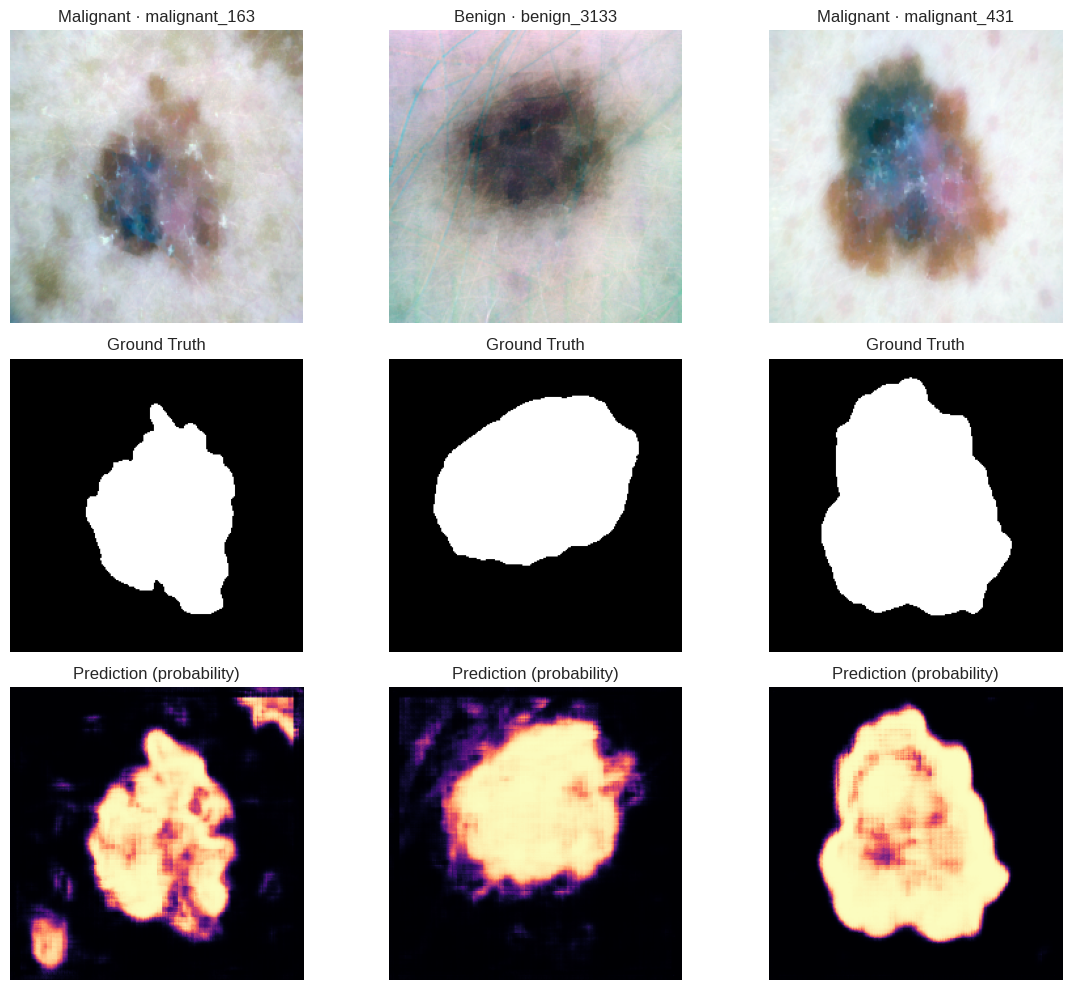

In [121]:
def visualize_predictions(
    model: nn.Module,
    loader: DataLoader,
    num_samples: int = 3,
) -> None:
    model.eval()
    collected = []

    with torch.no_grad():
        for batch in loader:
            features = batch["features"].to(DEVICE, non_blocking=True)
            logits = torch.sigmoid(model(features)).cpu()
            masks = batch["mask"].cpu()
            raw_ids: Sequence[str] = batch["raw_id"]
            class_names: Sequence[str] = batch["class_name"]
            image_paths: Sequence[Path] = batch["image_path"]

            for idx in range(features.size(0)):
                collected.append(
                    {
                        "raw_id": raw_ids[idx],
                        "class_name": class_names[idx],
                        "image_path": image_paths[idx],
                        "mask": masks[idx, 0].numpy(),
                        "prediction": logits[idx, 0].numpy(),
                    }
                )
                if len(collected) >= num_samples:
                    break
            if len(collected) >= num_samples:
                break

    if not collected:
        print("No samples collected for visualization.")
        return

    cols = len(collected)
    fig, axes = plt.subplots(3, cols, figsize=(4 * cols, 10))
    if cols == 1:
        axes = np.expand_dims(axes, axis=1)

    for col, sample in enumerate(collected):
        rgb_image = np.asarray(Image.open(sample["image_path"]).convert("RGB"))
        axes[0, col].imshow(rgb_image)
        axes[0, col].set_title(f"{sample['class_name']} · {sample['raw_id']}")
        axes[0, col].axis("off")

        axes[1, col].imshow(sample["mask"], cmap="gray")
        axes[1, col].set_title("Ground Truth")
        axes[1, col].axis("off")

        axes[2, col].imshow(sample["prediction"], cmap="magma", vmin=0.0, vmax=1.0)
        axes[2, col].set_title("Prediction (probability)")
        axes[2, col].axis("off")

    plt.tight_layout()
    plt.show()


visualize_predictions(model, test_loader, num_samples=3)